In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

import torch
import pyro
from pyro import distributions as dist
from pyro.infer.mcmc import NUTS, MCMC
from pyro.infer.abstract_infer import EmpiricalMarginal, TracePredictive

In [2]:
data = pd.read_csv("input/data-rental.txt")
data

,Y,Area
0,263.062,40.66
1,519.000,61.94
2,671.400,55.13
3,473.030,56.82
4,455.600,56.82
5,153.500,15.50
6,234.000,32.00
7,264.480,33.21
8,650.000,63.83
9,223.200,20.00


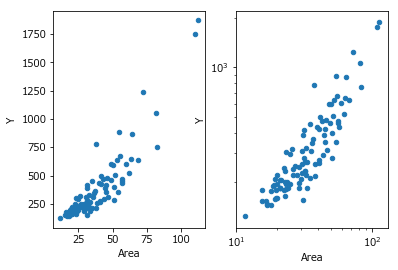

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=2)
data.plot(ax=axes[0], kind='scatter', x='Area', y='Y')
data.plot(ax=axes[1], kind='scatter', x='Area', y='Y', logx='Area', logy='Y')

In [4]:
area = torch.tensor(data.Area.values).float()
y = torch.tensor(data.Y.values).float()

## モデル式7-1
$$\mu_i = b_1 + b_2 Area_i$$
$$Y_i \sim Normal(\mu_i, \sigma_Y)$$

In [5]:
def model1(area, y):
    b1 = pyro.sample("b1", dist.Normal(0, 200))
    b2 = pyro.sample("b2", dist.Normal(0, 200))
    
    sigma_y = pyro.sample("sigma_y", dist.Uniform(0, 200))
    mu = b1 + b2 * area
    with pyro.plate("data", len(area)):
        pyro.sample("obs", dist.Normal(mu, sigma_y), obs=y)

In [6]:
hmc_kernel = NUTS(model1, adapt_step_size=True, jit_compile=True, ignore_jit_warnings=True)
posterior = MCMC(hmc_kernel, num_samples=1000, num_chains=4, warmup_steps=2000).run(area, y)

In [7]:
sites = ["b1", "b2", "sigma_y"]
mcmc_samples = posterior.marginal(sites).support(flatten=True)
mcmc_df = pd.DataFrame(EmpiricalMarginal(posterior, sites)._get_samples_and_weights()[0].reshape(-1, len(sites)).cpu().numpy(), columns=sites)
df_stats = mcmc_df.quantile([0.025, 0.25, 0.5, 0.75, 0.975]).T
df_stats["mean"] = mcmc_df.mean(0)
df_stats

,0.025,0.25,0.5,0.75,0.975,mean
b1,-202.659610,-165.548805,-146.160576,-126.387993,-88.517858,-145.901352
b2,12.507905,13.458468,13.940411,14.433094,15.324004,13.939400
sigma_y,113.316732,123.455532,129.801674,136.259766,150.921009,130.257629


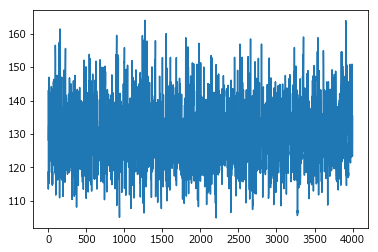

In [8]:
mcmc_df.sigma_y.plot()

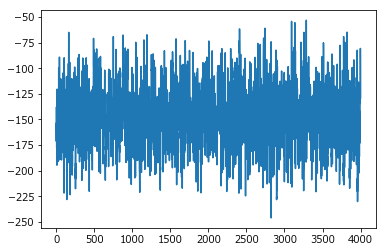

In [9]:
mcmc_df.b1.plot()

## モデル式7-2
$$\mu_i = b_1 + b_2 \log (Area_i)$$
$$\log(Y_i) \sim Normal(\mu_i, \sigma_Y)$$

In [10]:
def model2(area, y):
    b1 = pyro.sample("b1", dist.Normal(0, 100))
    b2 = pyro.sample("b2", dist.Normal(0, 100))
    
    sigma_y = pyro.sample("sigma_y", dist.Uniform(0, 100))
    mu = b1 + b2 * torch.log(area)
    with pyro.plate("data", len(area)):
        pyro.sample("obs", dist.Normal(mu, sigma_y), obs=torch.log(y))

In [11]:
log_hmc_kernel = NUTS(model2, adapt_step_size=True, jit_compile=True, ignore_jit_warnings=True)
log_posterior = MCMC(log_hmc_kernel, num_samples=1000, num_chains=4, warmup_steps=1000).run(area, y)

In [12]:
sites = ["b1", "b2", "sigma_y"]
log_mcmc_samples = log_posterior.marginal(sites).support(flatten=True)
log_mcmc_df = pd.DataFrame(EmpiricalMarginal(log_posterior, sites)._get_samples_and_weights()[0].reshape(-1, len(sites)).cpu().numpy(), columns=sites)
log_df_stats = log_mcmc_df.quantile([0.025, 0.25, 0.5, 0.75, 0.975]).T
log_df_stats["mean"] = log_mcmc_df.mean(0)
log_df_stats

,0.025,0.25,0.5,0.75,0.975,mean
b1,1.459161,1.712176,1.843584,1.962888,2.222817,1.840173
b2,0.998862,1.072526,1.107482,1.143288,1.216356,1.107945
sigma_y,0.223187,0.244016,0.256509,0.269959,0.299138,0.257714


In [13]:
def model1(area):
    b1 = pyro.sample("b1", dist.Normal(0, 100))
    b2 = pyro.sample("b2", dist.Normal(0, 100))
    
    sigma_y = pyro.sample("sigma_y", dist.Uniform(0, 100))
    mu = b1 + b2 * area
    pyro.sample("y", dist.Normal(mu, sigma_y))
predictive = TracePredictive(model1, posterior, num_samples=1000).run(torch.arange(0, 120).float())
pred_sample = pd.DataFrame(EmpiricalMarginal(predictive, "y")._get_samples_and_weights()[0].numpy())
def model2(area):
    b1 = pyro.sample("b1", dist.Normal(0, 100))
    b2 = pyro.sample("b2", dist.Normal(0, 100))
    
    sigma_y = pyro.sample("sigma_y", dist.Uniform(0, 100))
    mu = b1 + b2 * torch.log(area)
    pyro.sample("log_y", dist.Normal(mu, sigma_y))
log_predictive = TracePredictive(model2, log_posterior, num_samples=1000).run(torch.arange(0, 120).float())
log_pred_sample = pd.DataFrame(EmpiricalMarginal(log_predictive, "log_y")._get_samples_and_weights()[0].numpy())

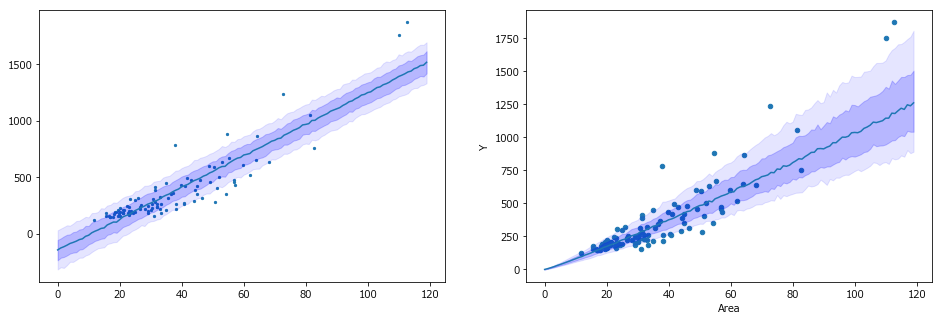

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].scatter(data.Area.values, data.Y.values, s=5)
axes[0].plot(np.arange(0, 120), pred_sample.mean(0).values)
axes[0].fill_between(np.arange(0, 120), pred_sample.quantile(0.1).values, pred_sample.quantile(0.9).values, color='blue', alpha=0.1)
axes[0].fill_between(np.arange(0, 120), pred_sample.quantile(0.25).values, pred_sample.quantile(0.75).values, color='blue', alpha=0.2)

data.plot(ax=axes[1], kind='scatter', x='Area', y='Y')
axes[1].plot(np.arange(0, 120), np.exp(log_pred_sample.mean(0).values))
axes[1].fill_between(np.arange(0, 120), np.exp(log_pred_sample).quantile(0.1).values, np.exp(log_pred_sample).quantile(0.9).values, color='blue', alpha=0.1)
axes[1].fill_between(np.arange(0, 120), np.exp(log_pred_sample).quantile(0.25).values, np.exp(log_pred_sample).quantile(0.75).values, color='blue', alpha=0.2)

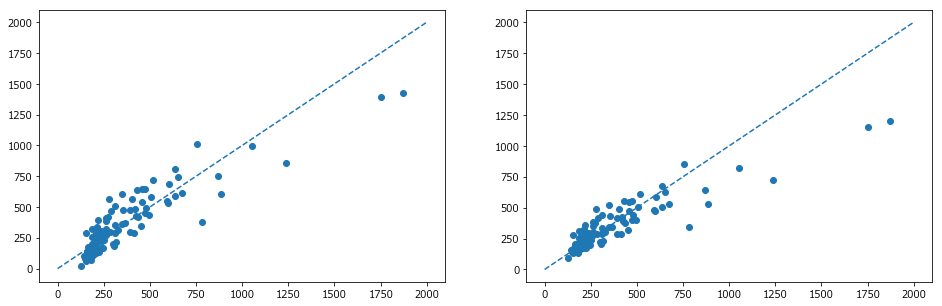

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
tmp_predictive = TracePredictive(model1, posterior, num_samples=1000).run(area)
tmp_pred_sample = pd.DataFrame(EmpiricalMarginal(tmp_predictive, "y")._get_samples_and_weights()[0].numpy())
axes[0].plot(np.arange(0, 2000), np.arange(0, 2000), '--')
axes[0].scatter(data.Y.values, tmp_pred_sample.mean(0).values)

tmp_predictive = TracePredictive(model2, log_posterior, num_samples=1000).run(area)
tmp_pred_sample = pd.DataFrame(EmpiricalMarginal(tmp_predictive, "log_y")._get_samples_and_weights()[0].numpy())
axes[1].plot(np.arange(0, 2000), np.arange(0, 2000), '--')
axes[1].scatter(data.Y.values, np.exp(tmp_pred_sample.mean(0).values))


In [16]:
kde = sm.nonparametric.KDEUnivariate(mcmc_df.sigma_y.values.astype("float64"))
kde.fit()
sigma_map = kde.support[np.argmax(kde.density)]

In [17]:
kde = sm.nonparametric.KDEUnivariate(log_mcmc_df.sigma_y.values.astype("float64"))
kde.fit()
sigma_map2 = kde.support[np.argmax(kde.density)]

In [18]:
mus1 = (mcmc_df.b1.values.reshape(-1, 1) + mcmc_df.b2.values.reshape(-1, 1) * data.Area.values.reshape(1, -1)) 
mus2 = (log_mcmc_df.b1.values.reshape(-1, 1) + log_mcmc_df.b2.values.reshape(-1, 1) * np.log(data.Area.values.reshape(1, -1)))

In [19]:
noise1 = data.Y.values - mus1.mean(0)
noise2 = np.log(data.Y.values) - mus2.mean(0)

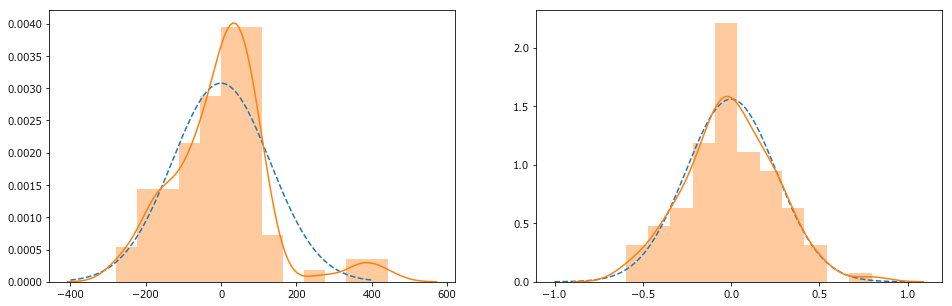

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
tmp_x = np.arange(-400, 400, 1)
tmp_y = stats.norm.pdf(tmp_x, loc=0, scale=sigma_map)
axes[0].plot(tmp_x, tmp_y, '--')
sns.distplot(noise1, ax=axes[0])

tmp_x = np.arange(-1, 1, 0.001)
tmp_y = stats.norm.pdf(tmp_x, loc=0, scale=sigma_map2)
axes[1].plot(tmp_x, tmp_y, '--')
sns.distplot(noise2, ax=axes[1])